In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from scipy import stats

#Set torch seed
torch.manual_seed(42)

In [2]:
# use the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
geom_cols = ['A-SCORE', 'BOARD', 'GCSE-G-SCORE', 'GENDER', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'INSTTYPE', 'LEA', 'INSTITUTE', 'STUDENT']
df = pd.read_csv("a-level-geography.txt", sep=" ", header=None, names=geom_cols)
print(df.head())

   A-SCORE  BOARD  GCSE-G-SCORE  GENDER  GTOT  GNUM  GCSE-MA-MAX  GCSE-MA-NUM  \
0      8.0      3             6       1    57   8.0            7            1   
1      8.0      3             6       1    50   8.0            6            1   
2      8.0      3             8       1    64   9.0            6            1   
3     10.0      3             8       1    57   8.0            6            1   
4      8.0      3             7       1    57   8.0            7            1   

   AGE  INST-GA-MN  INST-GA-SD  INSTTYPE  LEA  INSTITUTE  STUDENT  
0  1.0       0.856        0.51       7.0  1.0        1.0     25.0  
1 -6.0       0.856        0.51       7.0  1.0        1.0     51.0  
2  5.0       0.856        0.51       7.0  1.0        1.0     69.0  
3 -1.0       0.856        0.51       7.0  1.0        1.0     70.0  
4 -5.0       0.856        0.51       7.0  1.0        1.0     85.0  


In [4]:
#Create binary variable for Protected Group
df['PROTECTED'] = [1 if x == 1 else 0 for x in df['INSTTYPE']] 

#Create binary variable for achieving a C or above in A-Level Geometry
df['ABOVE_C'] = [1 if x >= 6 else 0 for x in df['A-SCORE']] 

In [5]:
df.groupby(["ABOVE_C", "PROTECTED"]).size()

ABOVE_C  PROTECTED
0        0             8040
         1             5774
1        0            12916
         1             6546
dtype: int64

In [6]:
# Create test and training set, apply standard scaler to non-binary variables

X = df[['GCSE-G-SCORE', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'GENDER', 'PROTECTED']].copy()
feature_names = list(X.columns)
y = df[['ABOVE_C']].copy()
X = X.to_numpy()
y = y.to_numpy()
X, y = shuffle(X, y)

y = y.squeeze()

In [7]:
## Unbalanced classes: apply class weights for both the predictor and the discriminator
neg_weight = y[y == 1].size /y[y == 0].size
class_weights = torch.as_tensor(neg_weight)

neg_A_weight = X[:,9][X[:,9] == 1].size /X[:,9][X[:,9] == 0].size
class_weights_A = torch.as_tensor(neg_A_weight)

In [8]:
print(feature_names)

['GCSE-G-SCORE', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'GENDER', 'PROTECTED']


In [9]:
protected = X[:,feature_names.index('PROTECTED')] == 1
other = X[:,feature_names.index('PROTECTED')] == 0
protected_mean_base = y[protected].mean()
other_mean_base = y[other].mean()
print(f'\tSample base rate: {protected_mean_base*100:.2f}% C or above for the protected group')
print(f'\tSample base rate: {other_mean_base*100:.2f}% C or above for the rest of the sample')

	Sample base rate: 53.13% C or above for the protected group
	Sample base rate: 61.63% C or above for the rest of the sample


In [10]:
def calc_FNR_FPR(y, y_pred):
    """
    Returns the FNR and FPR
    """
    y = y.numpy()
    y_pred = y_pred.numpy()
    fnr = 1 - y_pred[y == 1].mean()
    fpr = y_pred[y == 0].mean()
    
    return fnr, fpr

In [11]:
def plot_loss_accuracy(train_loss, valid_loss, train_acc, valid_acc, title):
    #plots the loss and accuracy of training and validation set during training
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss, 'b')
    ax1.plot(valid_loss, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title(title)
    ax1.legend(['Train', 'Validation'])  
    
    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(train_acc, 'b')
    ax1.plot(valid_acc, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    ax1.legend(['Train', 'Validation'])

In [57]:
class Adv_full(nn.Module):
      def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 1)
        self.linear2 = nn.Linear(3,1)
        self.c = torch.nn.Parameter(torch.randn(1))
      
      def forward(self, x, y):
        pred_logit = self.linear1(x)
        y_pred = torch.sigmoid(pred_logit)
        y_pred = torch.squeeze(y_pred)
        s = torch.sigmoid((1 + torch.abs(self.c)) * torch.squeeze(pred_logit))
        s_vec = torch.stack([s, s*y, s*(1-y)], dim=1)
        z = torch.sigmoid(self.linear2(s_vec))
        z = torch.squeeze(z)
        return y_pred, z

In [58]:
def train_Ad(model, iterator, optimizer, optimizer_Ad, criterion, criterion_Ad, a):
    
    epoch_loss = 0
    epoch_loss_A = 0
    epoch_acc = 0
    epoch_acc_A = 0

    e_pred_probs = np.array([])
    e_preds      = np.array([])
    e_labels = np.array([])
    model.train()

    for i, data in enumerate(iterator, 0):
        n = 0
        if a == 500:
            a = 0.1*np.sqrt(i)

        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_Ad.zero_grad()

        # Run adversary model
        y_pred, z_pred = model(inputs, labels)
        loss_A = criterion_Ad(z_pred, inputs[:,9])
        loss_A.backward(retain_graph=True)
        for name, param in model.named_parameters():
            if 'linear1' in name and 'weight' in name:
                dA_dW = param.grad
            elif 'linear1' in name and 'bias' in name:
                dA_db = param.grad
        z_round = torch.round(z_pred.detach().cpu().data)
        acc_A = accuracy_score(inputs[:,9].detach().cpu(), z_round)

        # Alternative updates between Adversary and Predictor
        if i == 0:
            optimizer_Ad.step()
        elif (i % 2) != 0:
            optimizer_Ad.step()
        
        # Keep track of adversary loss
        epoch_loss_A += loss_A.item()
        epoch_acc_A += acc_A.item()

        # 2. Train Predictor
        # Zero gradients
        optimizer.zero_grad()
        # Run predictor and adversary model      
        pred = torch.round(y_pred.detach().cpu().data) 
        loss = criterion(y_pred, labels)
        acc = accuracy_score(labels.detach().cpu(), pred)
        e_pred_probs = np.append(e_pred_probs, pred)
        e_preds = np.append(e_preds, pred)
        e_labels = np.append(e_labels,labels.detach().cpu())
        loss.backward()
        if i != 0:
            if (i % 2) == 0:
                n += 1
                # Perform backprop on the predictor loss, update the gradients based on the expression in Zhang et al.
                unit_protect_W = torch.norm(dA_dW)
                unit_protect_b = torch.norm(dA_db)
                model.linear1.weight.grad -= a*torch.sum(model.linear1.weight.grad * unit_protect_W) * unit_protect_W
                model.linear1.weight.grad -= a * dA_dW
                model.linear1.bias.grad -= a*torch.sum(model.linear1.bias.grad * unit_protect_b) * unit_protect_b     
                model.linear1.bias.grad -= a * dA_db   
        # Keep track of predictor loss
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        optimizer.step()
    
    f1 =  f1_score(e_labels,e_preds)
    auc = roc_auc_score(e_labels,e_pred_probs) 
    
    return epoch_loss/(len(iterator)) , epoch_acc / (len(iterator)), f1, auc, epoch_loss_A/(len(iterator)), epoch_acc_A/(len(iterator))


def evaluate_Ad(model, iterator, criterion, criterion_Ad):
    
    epoch_loss = 0
    epoch_loss_A = 0
    epoch_acc = 0
    epoch_acc_A = 0
    epoch_f1 = 0
    epoch_f1_o = 0
    epoch_f1_p = 0
    epoch_auc = 0
    epoch_prot_mean = 0
    epoch_other_mean = 0
    epoch_prot_fpr_mean = 0
    epoch_other_fpr_mean = 0
    epoch_prot_fnr_mean = 0
    epoch_other_fnr_mean = 0
    epoch_acc_p = 0
    epoch_acc_o = 0
    

    e_pred_probs = np.array([])
    e_preds      = np.array([])
    e_labels = np.array([])
    model.eval()
    
    with torch.no_grad():
    
        for i, data in enumerate(iterator, 0):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            y_pred, z_pred = model(inputs, labels)
            test_predictions = torch.round(y_pred.data) 
            
            loss = criterion(y_pred, labels)
            loss_A = criterion_Ad(z_pred, inputs[:,9])
            
            pred = torch.round(y_pred.detach().cpu().data) 
            acc = accuracy_score(labels.detach().cpu(), pred)
            z_round = torch.round(z_pred.detach().cpu().data)
            acc_A = accuracy_score(inputs[:,9].detach().cpu(), z_round)
            prot = inputs[:,feature_names.index('PROTECTED')] == 1
            other = inputs[:,feature_names.index('PROTECTED')] == 0
            acc_p = accuracy_score(labels.detach().cpu()[prot], pred[prot])
            acc_o = accuracy_score(labels.detach().cpu()[other], pred[other])
            f1_p = f1_score(labels.detach().cpu()[prot], pred[prot], zero_division=1)
            f1_o = f1_score(labels.detach().cpu()[other], pred[other], zero_division=1)
            prot_mean = pred[prot].mean()
            other_mean = pred[other].mean()

            # Check these expressions for fpr and fnr
            prot_fnr, prot_fpr = calc_FNR_FPR(labels.detach().cpu()[prot], pred[prot])
            other_fnr, other_fpr = calc_FNR_FPR(labels.detach().cpu()[other], pred[other])
            e_pred_probs = np.append(e_pred_probs, y_pred.detach().cpu())
            e_preds = np.append(e_preds, pred.detach().cpu())
            e_labels = np.append(e_labels,labels.detach().cpu())
            epoch_loss += loss.item()
            epoch_loss_A += loss_A.item()
            epoch_acc += acc.item()
            epoch_acc_A += acc_A.item()
            epoch_prot_mean += prot_mean
            epoch_other_mean += other_mean
            epoch_prot_fpr_mean += prot_fpr
            epoch_other_fpr_mean += other_fpr
            epoch_prot_fnr_mean += prot_fnr
            epoch_other_fnr_mean += other_fnr
            epoch_acc_p += acc_p
            epoch_acc_o += acc_o
            epoch_f1_o += f1_o
            epoch_f1_p += f1_p


    f1 =  f1_score(e_labels,e_preds)
    auc = roc_auc_score(e_labels,e_pred_probs) 

    n = len(iterator)
    return epoch_loss/n , epoch_acc /n, epoch_loss_A/n, epoch_acc_A/n, f1, auc, e_preds, e_pred_probs, epoch_prot_mean/n, epoch_other_mean/n, epoch_prot_fpr_mean/n, epoch_other_fpr_mean/n, epoch_prot_fnr_mean/n, epoch_other_fnr_mean/n, epoch_acc_p/n, epoch_acc_o/n, epoch_f1_p/n, epoch_f1_o/n

Running combination:
alpha:  200
d:  2
Epoch: 01
	Train Loss: 9.297 | Train Acc: 69.78%
	 Val. Loss: 8.920 |  Val. Acc: 70.49%
	 Val Protected FPR: 0.472
	 Val Other FPR: 0.423
	 Val Protected FNR: 0.173
	 Val Other FNR: 0.192
Epoch: 11
	Train Loss: 11.891 | Train Acc: 69.90%
	 Val. Loss: 11.813 |  Val. Acc: 70.31%
	 Val Protected FPR: 0.470
	 Val Other FPR: 0.428
	 Val Protected FNR: 0.190
	 Val Other FNR: 0.197
Epoch: 21
	Train Loss: 11.446 | Train Acc: 69.61%
	 Val. Loss: 11.253 |  Val. Acc: 69.98%
	 Val Protected FPR: 0.478
	 Val Other FPR: 0.423
	 Val Protected FNR: 0.193
	 Val Other FNR: 0.207
Epoch: 31
	Train Loss: 8.266 | Train Acc: 60.00%
	 Val. Loss: 8.819 |  Val. Acc: 58.74%
	 Val Protected FPR: 0.571
	 Val Other FPR: 0.570
	 Val Protected FNR: 0.325
	 Val Other FNR: 0.290
Epoch: 41
	Train Loss: 11.984 | Train Acc: 64.78%
	 Val. Loss: 12.223 |  Val. Acc: 63.67%
	 Val Protected FPR: 0.570
	 Val Other FPR: 0.536
	 Val Protected FNR: 0.223
	 Val Other FNR: 0.234
Epoch: 51
	Trai

Epoch: 31
	Train Loss: 12.864 | Train Acc: 65.36%
	 Val. Loss: 12.620 |  Val. Acc: 66.44%
	 Val Protected FPR: 0.546
	 Val Other FPR: 0.503
	 Val Protected FNR: 0.216
	 Val Other FNR: 0.199
Epoch: 41
	Train Loss: 13.406 | Train Acc: 65.92%
	 Val. Loss: 13.156 |  Val. Acc: 66.74%
	 Val Protected FPR: 0.538
	 Val Other FPR: 0.495
	 Val Protected FNR: 0.216
	 Val Other FNR: 0.198
Epoch: 51
	Train Loss: 13.631 | Train Acc: 66.16%
	 Val. Loss: 13.356 |  Val. Acc: 66.86%
	 Val Protected FPR: 0.536
	 Val Other FPR: 0.492
	 Val Protected FNR: 0.218
	 Val Other FNR: 0.202
Epoch: 61
	Train Loss: 13.792 | Train Acc: 66.30%
	 Val. Loss: 13.498 |  Val. Acc: 66.92%
	 Val Protected FPR: 0.540
	 Val Other FPR: 0.488
	 Val Protected FNR: 0.214
	 Val Other FNR: 0.203
Epoch: 71
	Train Loss: 13.866 | Train Acc: 66.38%
	 Val. Loss: 13.458 |  Val. Acc: 67.07%
	 Val Protected FPR: 0.521
	 Val Other FPR: 0.482
	 Val Protected FNR: 0.227
	 Val Other FNR: 0.202
Epoch: 81
	Train Loss: 13.911 | Train Acc: 66.46%


Epoch: 61
	Train Loss: 13.524 | Train Acc: 66.36%
	 Val. Loss: 13.671 |  Val. Acc: 66.18%
	 Val Protected FPR: 0.498
	 Val Other FPR: 0.500
	 Val Protected FNR: 0.223
	 Val Other FNR: 0.221
Epoch: 71
	Train Loss: 13.656 | Train Acc: 66.53%
	 Val. Loss: 13.962 |  Val. Acc: 66.22%
	 Val Protected FPR: 0.501
	 Val Other FPR: 0.489
	 Val Protected FNR: 0.235
	 Val Other FNR: 0.220
Epoch: 81
	Train Loss: 13.749 | Train Acc: 66.66%
	 Val. Loss: 14.231 |  Val. Acc: 66.40%
	 Val Protected FPR: 0.491
	 Val Other FPR: 0.489
	 Val Protected FNR: 0.227
	 Val Other FNR: 0.222
Epoch: 91
	Train Loss: 13.758 | Train Acc: 66.73%
	 Val. Loss: 14.236 |  Val. Acc: 66.49%
	 Val Protected FPR: 0.498
	 Val Other FPR: 0.482
	 Val Protected FNR: 0.237
	 Val Other FNR: 0.221
Running combination:
alpha:  200
d:  2
Epoch: 01
	Train Loss: 10.151 | Train Acc: 70.05%
	 Val. Loss: 11.637 |  Val. Acc: 69.91%
	 Val Protected FPR: 0.490
	 Val Other FPR: 0.450
	 Val Protected FNR: 0.166
	 Val Other FNR: 0.196
Epoch: 11
	

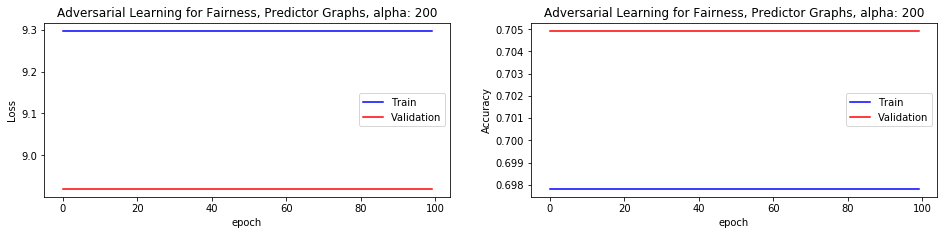

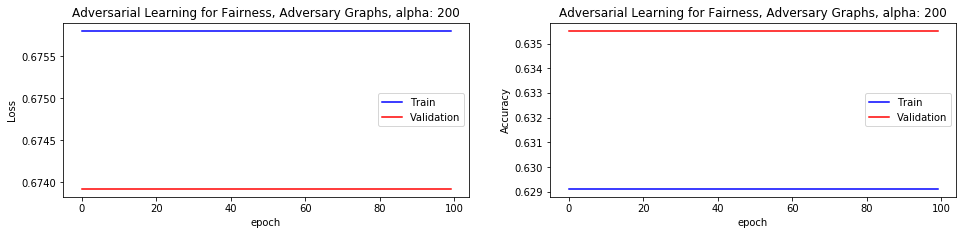

In [62]:
Adv_f1s = []
Adv_fnr_diffs = []
Adv_fpr_diffs = []
Adv_aucs = []
Adv_accs = []
Adv_accs_o = []
Adv_accs_p = []
Adv_fnr_fprs = []
Adv_fnr_ps = []
Adv_fnr_os = []
Adv_fpr_ps = []
Adv_fpr_os = []
n_splits = 0

a_range = [200]
epochs = 100
batch_size = 64
lr = 0.0001
d = 2

skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    n_splits +=1
    X_train_, X_test_ = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = StandardScaler()

    X_train_[:, 0:7] = scaler.fit_transform(X_train_[:, 0:7])
    X_test_[:, 0:7] = scaler.fit_transform(X_test_[:, 0:7])

    X_train = X_train_#[:,0:9]
    X_test = X_test_#[:,0:9]

    training_features_tensor = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
    training_labels_tensor = torch.tensor(y_train, requires_grad=False, dtype=torch.float)

    test_features_tensor = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
    test_labels_tensor = torch.tensor(y_test, requires_grad=False, dtype=torch.float)
    
    # create Tensor datasets
    train_data = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
    val_data = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
    valid_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = False)

    d_s = []
    a_s = []
    fnr_diffs = []
    fpr_diffs = []
    fnr_fprs = []
    accs = []
    accs_o = []
    accs_p = []
    best_epochs = []
    f1s = []
    fnr_os = []
    fnr_ps = []
    fpr_os = []
    fpr_ps = []
    aucs = []

    for a in a_range:
        e_valid_acc = 0
        
        train_losses = []
        train_losses_A = []
        train_accs = []
        train_accs_A = []
        val_losses = []
        val_losses_A = []
        val_accs = []
        val_accs_A = []
        # create Tensor datasets as usual
        train_data = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
        val_data = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)

        # dataloaders
        train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
        valid_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = False)

        model = Adv_full().to(device)
        # Define the Predictor and Adversary parameters so they can be passed to the relevant Optimizer
        P_params = [model.linear1.weight, model.linear1.bias]
        A_params = [model.linear2.weight, model.linear2.bias, model.c]

        # loss function - using cross entropy loss
        criterion = nn.BCELoss(weight = class_weights)
        criterion_A = nn.BCELoss()
        optimizer = optim.SGD(P_params, lr=lr)
        optimizer_A = optim.SGD(A_params, lr=lr)

        print("Running combination:")
        print("alpha: ", a)
        print("d: ", d)

        for epoch in range(epochs):

            train_loss, train_acc, train_f1, train_auc, train_loss_A, train_acc_A = train_Ad(model, train_loader, optimizer, optimizer_A, criterion, criterion_A, a)
            valid_loss, valid_acc, valid_loss_A, valid_acc_A, valid_f1, valid_auc, _, _, p_mean, o_mean, p_fpr, o_fpr, p_fnr, o_fnr, acc_p, acc_o, f1_p, f1_o = evaluate_Ad(model, valid_loader, criterion, criterion_A)

            fnr_diff = np.absolute(o_fnr - p_fnr)
            fpr_diff = np.absolute(o_fpr - p_fpr)
            fnr_fpr = (fnr_diff + fpr_diff)/2

            if valid_acc > e_valid_acc:
                    e_train_loss = train_loss
                    e_train_acc = train_acc
                    e_train_f1 = train_f1
                    e_train_auc = train_auc
                    e_train_loss_A = train_loss_A
                    e_train_acc_A = train_acc_A

                    e_valid_loss = valid_loss
                    e_valid_loss_A = valid_loss_A
                    e_valid_acc = valid_acc
                    e_valid_acc_A = valid_acc_A
                    e_valid_f1 = valid_f1
                    e_valid_auc = valid_auc
                    e_valid_fnr_diff = fnr_diff
                    e_valid_fpr_diff = fpr_diff
                    e_valid_fnr_fpr = fnr_fpr
                    e_valid_o_fnr = o_fnr
                    e_valid_o_fpr = o_fpr
                    e_valid_p_fnr = p_fnr
                    e_valid_p_fpr = p_fpr
                    e_valid_o_acc = acc_o
                    e_valid_p_acc = acc_p
                    e_valid_o_f1 = f1_o
                    e_valid_p_f1 = f1_p
                    best_epoch = epoch
                    torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': e_valid_loss,
                    }, 'best_adv_model.pt')

            if epoch%(epochs//10) == 0:

                print(f'Epoch: {epoch+1:02}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print(f'\t Val Protected FPR: {p_fpr:.3f}')
                print(f'\t Val Other FPR: {o_fpr:.3f}')
                print(f'\t Val Protected FNR: {p_fnr:.3f}')
                print(f'\t Val Other FNR: {o_fnr:.3f}')

            train_losses.append(e_train_loss)
            train_accs.append(e_train_acc)
            val_losses.append(e_valid_loss)
            val_accs.append(e_valid_acc)
            train_losses_A.append(e_train_loss_A)
            train_accs_A.append(e_train_acc_A)
            val_losses_A.append(e_valid_loss_A)
            val_accs_A.append(e_valid_acc_A)
            
        if n_splits == 1:
            title = ("Adversarial Learning for Fairness, Predictor Graphs, alpha: " + str(a))
            plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, title)
            title_A = ("Adversarial Learning for Fairness, Adversary Graphs, alpha: " + str(a))
            plot_loss_accuracy(train_losses_A, val_losses_A, train_accs_A, val_accs_A, title_A)
        a_s.append(a)
        fnr_diffs.append(e_valid_fnr_diff)
        fpr_diffs.append(e_valid_fpr_diff)
        fnr_fprs.append(e_valid_fnr_fpr)
        fnr_os.append(e_valid_o_fnr)
        fnr_ps.append(e_valid_p_fnr)
        fpr_os.append(e_valid_o_fpr)
        fpr_ps.append(e_valid_p_fpr)
        f1s.append(e_valid_f1)
        aucs.append(e_valid_auc)
        accs.append(e_valid_acc)
        accs_o.append(e_valid_o_acc)
        accs_p.append(e_valid_p_acc)
    Adv_f1s.append(f1s)
    Adv_fnr_diffs.append(fnr_diffs)
    Adv_fpr_diffs.append(fpr_diffs)
    Adv_aucs.append(aucs)
    Adv_accs.append(accs)
    Adv_accs_o.append(accs_o)
    Adv_accs_p.append(accs_p)
    Adv_fnr_fprs.append(fnr_fprs)
    Adv_fnr_ps.append(fnr_ps)
    Adv_fnr_os.append(fnr_os)
    Adv_fpr_ps.append(fpr_ps)
    Adv_fpr_os.append(fpr_os)


In [63]:
data_1 = {'a': a_range, 'mean acc': np.mean(Adv_accs, axis=0), 'std acc': np.std(Adv_accs, axis=0),\
        'mean f1': np.mean(Adv_f1s, axis=0), 'std f1': np.std(Adv_f1s, axis=0), 'mean auc': np.mean(Adv_aucs, axis=0),\
        'std auc': np.std(Adv_aucs, axis=0), 'mean acc prot': np.mean(Adv_accs_p, axis=0),\
        'std acc prot': np.std(Adv_accs_p, axis=0), 'mean acc other': np.mean(Adv_accs_o, axis=0), 'std acc other': np.std(Adv_accs_o, axis=0),\
        'mean FPR diff': np.mean(Adv_fpr_diffs, axis=0), 'std FPR diff': np.std(Adv_fpr_diffs, axis=0),\
        'mean FNR diff': np.mean(Adv_fnr_diffs, axis=0), 'std FNR diff': np.std(Adv_fnr_diffs, axis=0),\
        'mean av diffs': np.mean(Adv_fnr_fprs, axis=0), 'std av diffs': np.std(Adv_fnr_fprs, axis=0)}

results_df_1 = pd.DataFrame (data_1, columns = ['a', 'mean acc', 'std acc', 'mean f1', 'std f1', 'mean auc', 'std auc', \
                                            'mean acc prot', 'std acc prot', 'mean acc other', 'std acc other', \
                                            'mean FPR diff', 'std FPR diff', 'mean FNR diff', 'std FNR diff', \
                                            'mean av diffs', 'std av diffs'])


#lr_results = {'a': 'LR Baseline', 'f1': LR_f1, 'auc': LR_auc, 'FNR Diff': LR_fnr_diff, 'FPR Diff': LR_fpr_diff, 'Mean FNR + FPR Diff': LR_fnr_fpr_av}

results_df_1 = results_df_1.replace(500, 'var')

results_df_1 = results_df_1.sort_values(by=['mean av diffs'])

print(results_df_1)

     a  mean acc  std acc   mean f1   std f1  mean auc   std auc  \
0  200  0.701344  0.00565  0.760853  0.00441  0.714092  0.009716   

   mean acc prot  std acc prot  mean acc other  std acc other  mean FPR diff  \
0       0.679547      0.010444        0.714004       0.008094       0.032797   

   std FPR diff  mean FNR diff  std FNR diff  mean av diffs  std av diffs  
0      0.022732        0.01555      0.008564       0.024173       0.01093  


In [66]:
print(np.mean(Adv_fpr_ps))
print(np.mean(Adv_fpr_os))
print(np.mean(Adv_fnr_ps))
print(np.mean(Adv_fnr_os))

0.47439605093632753
0.44159928272263366
0.18383347157102364
0.18858860650887857


Experiment with different values of alpha

Running combination:
alpha:  0
d:  2
Epoch: 01
	Train Loss: 1.114 | Train Acc: 40.07%
	 Val. Loss: 1.104 |  Val. Acc: 40.26%
	 Val Protected FPR: 0.217
	 Val Other FPR: 0.489
	 Val Protected FNR: 0.897
	 Val Other FNR: 0.682
Epoch: 11
	Train Loss: 0.926 | Train Acc: 61.44%
	 Val. Loss: 0.919 |  Val. Acc: 63.40%
	 Val Protected FPR: 0.124
	 Val Other FPR: 0.354
	 Val Protected FNR: 0.653
	 Val Other FNR: 0.332
Epoch: 21
	Train Loss: 0.837 | Train Acc: 71.43%
	 Val. Loss: 0.830 |  Val. Acc: 72.39%
	 Val Protected FPR: 0.153
	 Val Other FPR: 0.375
	 Val Protected FNR: 0.436
	 Val Other FNR: 0.190
Epoch: 31
	Train Loss: 0.791 | Train Acc: 73.45%
	 Val. Loss: 0.783 |  Val. Acc: 74.58%
	 Val Protected FPR: 0.165
	 Val Other FPR: 0.390
	 Val Protected FNR: 0.337
	 Val Other FNR: 0.161
Epoch: 41
	Train Loss: 0.766 | Train Acc: 74.11%
	 Val. Loss: 0.757 |  Val. Acc: 75.03%
	 Val Protected FPR: 0.207
	 Val Other FPR: 0.401
	 Val Protected FNR: 0.300
	 Val Other FNR: 0.154
Epoch: 51
	Train Loss: 

Epoch: 31
	Train Loss: 11.897 | Train Acc: 70.17%
	 Val. Loss: 11.632 |  Val. Acc: 70.58%
	 Val Protected FPR: 0.480
	 Val Other FPR: 0.420
	 Val Protected FNR: 0.176
	 Val Other FNR: 0.191
Epoch: 41
	Train Loss: 11.891 | Train Acc: 70.14%
	 Val. Loss: 11.642 |  Val. Acc: 70.55%
	 Val Protected FPR: 0.472
	 Val Other FPR: 0.429
	 Val Protected FNR: 0.179
	 Val Other FNR: 0.190
Epoch: 51
	Train Loss: 11.895 | Train Acc: 70.12%
	 Val. Loss: 11.620 |  Val. Acc: 70.61%
	 Val Protected FPR: 0.477
	 Val Other FPR: 0.424
	 Val Protected FNR: 0.171
	 Val Other FNR: 0.191
Epoch: 61
	Train Loss: 11.903 | Train Acc: 70.11%
	 Val. Loss: 11.630 |  Val. Acc: 70.58%
	 Val Protected FPR: 0.479
	 Val Other FPR: 0.421
	 Val Protected FNR: 0.173
	 Val Other FNR: 0.193
Epoch: 71
	Train Loss: 11.905 | Train Acc: 70.12%
	 Val. Loss: 11.639 |  Val. Acc: 70.58%
	 Val Protected FPR: 0.477
	 Val Other FPR: 0.416
	 Val Protected FNR: 0.174
	 Val Other FNR: 0.191
Epoch: 81
	Train Loss: 11.907 | Train Acc: 70.10%


Epoch: 61
	Train Loss: 0.758 | Train Acc: 73.60%
	 Val. Loss: 0.761 |  Val. Acc: 72.90%
	 Val Protected FPR: 0.400
	 Val Other FPR: 0.351
	 Val Protected FNR: 0.193
	 Val Other FNR: 0.198
Epoch: 71
	Train Loss: 0.748 | Train Acc: 73.86%
	 Val. Loss: 0.750 |  Val. Acc: 73.44%
	 Val Protected FPR: 0.386
	 Val Other FPR: 0.358
	 Val Protected FNR: 0.205
	 Val Other FNR: 0.189
Epoch: 81
	Train Loss: 0.740 | Train Acc: 74.08%
	 Val. Loss: 0.743 |  Val. Acc: 73.74%
	 Val Protected FPR: 0.372
	 Val Other FPR: 0.356
	 Val Protected FNR: 0.204
	 Val Other FNR: 0.183
Epoch: 91
	Train Loss: 0.735 | Train Acc: 74.23%
	 Val. Loss: 0.737 |  Val. Acc: 73.68%
	 Val Protected FPR: 0.364
	 Val Other FPR: 0.360
	 Val Protected FNR: 0.203
	 Val Other FNR: 0.185
Running combination:
alpha:  1
d:  2
Epoch: 01
	Train Loss: 0.976 | Train Acc: 53.89%
	 Val. Loss: 0.975 |  Val. Acc: 53.43%
	 Val Protected FPR: 0.822
	 Val Other FPR: 0.534
	 Val Protected FNR: 0.120
	 Val Other FNR: 0.434
Epoch: 11
	Train Loss: 

Epoch: 91
	Train Loss: 13.033 | Train Acc: 67.70%
	 Val. Loss: 12.867 |  Val. Acc: 68.45%
	 Val Protected FPR: 0.590
	 Val Other FPR: 0.502
	 Val Protected FNR: 0.153
	 Val Other FNR: 0.157
Running combination:
alpha:  5000
d:  2
Epoch: 01
	Train Loss: 11.578 | Train Acc: 70.02%
	 Val. Loss: 11.469 |  Val. Acc: 70.58%
	 Val Protected FPR: 0.493
	 Val Other FPR: 0.427
	 Val Protected FNR: 0.179
	 Val Other FNR: 0.177
Epoch: 11
	Train Loss: 11.644 | Train Acc: 70.14%
	 Val. Loss: 11.469 |  Val. Acc: 70.58%
	 Val Protected FPR: 0.496
	 Val Other FPR: 0.418
	 Val Protected FNR: 0.189
	 Val Other FNR: 0.180
Epoch: 21
	Train Loss: 11.645 | Train Acc: 70.14%
	 Val. Loss: 11.470 |  Val. Acc: 70.58%
	 Val Protected FPR: 0.504
	 Val Other FPR: 0.432
	 Val Protected FNR: 0.181
	 Val Other FNR: 0.179
Epoch: 31
	Train Loss: 11.645 | Train Acc: 70.14%
	 Val. Loss: 11.471 |  Val. Acc: 70.55%
	 Val Protected FPR: 0.494
	 Val Other FPR: 0.423
	 Val Protected FNR: 0.187
	 Val Other FNR: 0.177
Epoch: 41


Epoch: 21
	Train Loss: 0.886 | Train Acc: 65.18%
	 Val. Loss: 0.880 |  Val. Acc: 64.78%
	 Val Protected FPR: 0.487
	 Val Other FPR: 0.585
	 Val Protected FNR: 0.237
	 Val Other FNR: 0.207
Epoch: 31
	Train Loss: 0.846 | Train Acc: 68.82%
	 Val. Loss: 0.842 |  Val. Acc: 68.39%
	 Val Protected FPR: 0.414
	 Val Other FPR: 0.524
	 Val Protected FNR: 0.244
	 Val Other FNR: 0.182
Epoch: 41
	Train Loss: 0.817 | Train Acc: 70.71%
	 Val. Loss: 0.816 |  Val. Acc: 69.92%
	 Val Protected FPR: 0.369
	 Val Other FPR: 0.507
	 Val Protected FNR: 0.258
	 Val Other FNR: 0.169


C:\Users\cathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
C:\Users\cathe\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Epoch: 51
	Train Loss: 0.797 | Train Acc: 71.61%
	 Val. Loss: 0.797 |  Val. Acc: 70.91%
	 Val Protected FPR: 0.343
	 Val Other FPR: 0.495
	 Val Protected FNR: 0.249
	 Val Other FNR: 0.164
Epoch: 61
	Train Loss: 0.781 | Train Acc: 72.47%
	 Val. Loss: 0.783 |  Val. Acc: 71.27%
	 Val Protected FPR: 0.321
	 Val Other FPR: 0.499
	 Val Protected FNR: 0.250
	 Val Other FNR: 0.160
Epoch: 71
	Train Loss: 0.769 | Train Acc: 73.05%
	 Val. Loss: 0.773 |  Val. Acc: 71.45%
	 Val Protected FPR: 0.315
	 Val Other FPR: 0.482
	 Val Protected FNR: 0.256
	 Val Other FNR: 0.164
Epoch: 81
	Train Loss: 0.760 | Train Acc: 73.47%
	 Val. Loss: 0.764 |  Val. Acc: 71.66%
	 Val Protected FPR: 0.305
	 Val Other FPR: 0.476
	 Val Protected FNR: 0.266
	 Val Other FNR: 0.162
Epoch: 91
	Train Loss: 0.752 | Train Acc: 73.75%
	 Val. Loss: 0.758 |  Val. Acc: 72.03%
	 Val Protected FPR: 0.310
	 Val Other FPR: 0.472
	 Val Protected FNR: 0.261
	 Val Other FNR: 0.163
Running combination:
alpha:  50
d:  2
Epoch: 01
	Train Loss:

Epoch: 81
	Train Loss: 11.583 | Train Acc: 70.32%
	 Val. Loss: 12.069 |  Val. Acc: 69.05%
	 Val Protected FPR: 0.487
	 Val Other FPR: 0.471
	 Val Protected FNR: 0.207
	 Val Other FNR: 0.183
Epoch: 91
	Train Loss: 11.582 | Train Acc: 70.32%
	 Val. Loss: 12.068 |  Val. Acc: 69.05%
	 Val Protected FPR: 0.491
	 Val Other FPR: 0.471
	 Val Protected FNR: 0.203
	 Val Other FNR: 0.184
Running combination:
alpha:  50000
d:  2
Epoch: 01
	Train Loss: 11.505 | Train Acc: 70.05%
	 Val. Loss: 12.048 |  Val. Acc: 69.05%
	 Val Protected FPR: 0.481
	 Val Other FPR: 0.471
	 Val Protected FNR: 0.199
	 Val Other FNR: 0.186
Epoch: 11
	Train Loss: 11.561 | Train Acc: 70.30%
	 Val. Loss: 12.048 |  Val. Acc: 69.05%
	 Val Protected FPR: 0.478
	 Val Other FPR: 0.470
	 Val Protected FNR: 0.204
	 Val Other FNR: 0.183
Epoch: 21
	Train Loss: 11.561 | Train Acc: 70.30%
	 Val. Loss: 12.048 |  Val. Acc: 69.05%
	 Val Protected FPR: 0.478
	 Val Other FPR: 0.469
	 Val Protected FNR: 0.212
	 Val Other FNR: 0.185
Epoch: 31

Epoch: 11
	Train Loss: 5.004 | Train Acc: 55.62%
	 Val. Loss: 5.125 |  Val. Acc: 56.97%
	 Val Protected FPR: 0.644
	 Val Other FPR: 0.574
	 Val Protected FNR: 0.254
	 Val Other FNR: 0.329
Epoch: 21
	Train Loss: 8.244 | Train Acc: 59.41%
	 Val. Loss: 8.078 |  Val. Acc: 60.67%
	 Val Protected FPR: 0.573
	 Val Other FPR: 0.558
	 Val Protected FNR: 0.263
	 Val Other FNR: 0.283
Epoch: 31
	Train Loss: 9.925 | Train Acc: 61.56%
	 Val. Loss: 9.657 |  Val. Acc: 62.71%
	 Val Protected FPR: 0.563
	 Val Other FPR: 0.529
	 Val Protected FNR: 0.242
	 Val Other FNR: 0.264
Epoch: 41
	Train Loss: 11.003 | Train Acc: 62.64%
	 Val. Loss: 10.737 |  Val. Acc: 63.64%
	 Val Protected FPR: 0.543
	 Val Other FPR: 0.516
	 Val Protected FNR: 0.223
	 Val Other FNR: 0.256
Epoch: 51
	Train Loss: 11.757 | Train Acc: 63.19%
	 Val. Loss: 11.491 |  Val. Acc: 64.27%
	 Val Protected FPR: 0.526
	 Val Other FPR: 0.514
	 Val Protected FNR: 0.225
	 Val Other FNR: 0.250
Epoch: 61
	Train Loss: 12.346 | Train Acc: 63.40%
	 Val.

Epoch: 41
	Train Loss: 11.619 | Train Acc: 70.15%
	 Val. Loss: 11.533 |  Val. Acc: 70.37%
	 Val Protected FPR: 0.449
	 Val Other FPR: 0.458
	 Val Protected FNR: 0.200
	 Val Other FNR: 0.172
Epoch: 51
	Train Loss: 11.619 | Train Acc: 70.15%
	 Val. Loss: 11.533 |  Val. Acc: 70.37%
	 Val Protected FPR: 0.456
	 Val Other FPR: 0.456
	 Val Protected FNR: 0.191
	 Val Other FNR: 0.171
Epoch: 61
	Train Loss: 11.619 | Train Acc: 70.15%
	 Val. Loss: 11.533 |  Val. Acc: 70.37%
	 Val Protected FPR: 0.458
	 Val Other FPR: 0.458
	 Val Protected FNR: 0.193
	 Val Other FNR: 0.174
Epoch: 71
	Train Loss: 11.620 | Train Acc: 70.15%
	 Val. Loss: 11.533 |  Val. Acc: 70.37%
	 Val Protected FPR: 0.451
	 Val Other FPR: 0.462
	 Val Protected FNR: 0.198
	 Val Other FNR: 0.172
Epoch: 81
	Train Loss: 11.619 | Train Acc: 70.15%
	 Val. Loss: 11.533 |  Val. Acc: 70.37%
	 Val Protected FPR: 0.465
	 Val Other FPR: 0.457
	 Val Protected FNR: 0.203
	 Val Other FNR: 0.170
Epoch: 91
	Train Loss: 11.619 | Train Acc: 70.15%


Epoch: 71
	Train Loss: 12.862 | Train Acc: 63.77%
	 Val. Loss: 12.710 |  Val. Acc: 63.76%
	 Val Protected FPR: 0.555
	 Val Other FPR: 0.478
	 Val Protected FNR: 0.261
	 Val Other FNR: 0.262
Epoch: 81
	Train Loss: 13.249 | Train Acc: 63.89%
	 Val. Loss: 13.111 |  Val. Acc: 63.97%
	 Val Protected FPR: 0.546
	 Val Other FPR: 0.476
	 Val Protected FNR: 0.255
	 Val Other FNR: 0.262
Epoch: 91
	Train Loss: 13.573 | Train Acc: 64.10%
	 Val. Loss: 13.453 |  Val. Acc: 64.12%
	 Val Protected FPR: 0.537
	 Val Other FPR: 0.473
	 Val Protected FNR: 0.262
	 Val Other FNR: 0.263
Running combination:
alpha:  200
d:  2
Epoch: 01
	Train Loss: 9.403 | Train Acc: 69.54%
	 Val. Loss: 10.748 |  Val. Acc: 71.15%
	 Val Protected FPR: 0.465
	 Val Other FPR: 0.433
	 Val Protected FNR: 0.176
	 Val Other FNR: 0.180
Epoch: 11
	Train Loss: 8.677 | Train Acc: 68.82%
	 Val. Loss: 10.097 |  Val. Acc: 70.52%
	 Val Protected FPR: 0.465
	 Val Other FPR: 0.431
	 Val Protected FNR: 0.176
	 Val Other FNR: 0.193
Epoch: 21
	Tr

Running combination:
alpha:  500
d:  2
Epoch: 01
	Train Loss: 1.057 | Train Acc: 46.17%
	 Val. Loss: 1.043 |  Val. Acc: 47.60%
	 Val Protected FPR: 0.365
	 Val Other FPR: 0.500
	 Val Protected FNR: 0.742
	 Val Other FNR: 0.498
Epoch: 11
	Train Loss: 0.911 | Train Acc: 62.56%
	 Val. Loss: 0.901 |  Val. Acc: 63.70%
	 Val Protected FPR: 0.281
	 Val Other FPR: 0.468
	 Val Protected FNR: 0.535
	 Val Other FNR: 0.246
Epoch: 21
	Train Loss: 0.837 | Train Acc: 69.41%
	 Val. Loss: 0.829 |  Val. Acc: 70.58%
	 Val Protected FPR: 0.252
	 Val Other FPR: 0.436
	 Val Protected FNR: 0.387
	 Val Other FNR: 0.172
Epoch: 31
	Train Loss: 0.796 | Train Acc: 72.06%
	 Val. Loss: 0.790 |  Val. Acc: 73.05%
	 Val Protected FPR: 0.253
	 Val Other FPR: 0.428
	 Val Protected FNR: 0.327
	 Val Other FNR: 0.146
Epoch: 41
	Train Loss: 0.772 | Train Acc: 73.05%
	 Val. Loss: 0.766 |  Val. Acc: 73.98%
	 Val Protected FPR: 0.242
	 Val Other FPR: 0.419
	 Val Protected FNR: 0.291
	 Val Other FNR: 0.139
Epoch: 51
	Train Loss

Epoch: 31
	Train Loss: 13.031 | Train Acc: 65.56%
	 Val. Loss: 12.636 |  Val. Acc: 66.98%
	 Val Protected FPR: 0.499
	 Val Other FPR: 0.511
	 Val Protected FNR: 0.212
	 Val Other FNR: 0.193
Epoch: 41
	Train Loss: 13.454 | Train Acc: 65.96%
	 Val. Loss: 13.149 |  Val. Acc: 67.22%
	 Val Protected FPR: 0.487
	 Val Other FPR: 0.510
	 Val Protected FNR: 0.209
	 Val Other FNR: 0.197
Epoch: 51
	Train Loss: 13.649 | Train Acc: 66.21%
	 Val. Loss: 13.360 |  Val. Acc: 67.46%
	 Val Protected FPR: 0.502
	 Val Other FPR: 0.504
	 Val Protected FNR: 0.221
	 Val Other FNR: 0.196
Epoch: 61
	Train Loss: 13.738 | Train Acc: 66.33%
	 Val. Loss: 13.527 |  Val. Acc: 67.64%
	 Val Protected FPR: 0.479
	 Val Other FPR: 0.509
	 Val Protected FNR: 0.213
	 Val Other FNR: 0.191
Epoch: 71
	Train Loss: 13.858 | Train Acc: 66.49%
	 Val. Loss: 13.527 |  Val. Acc: 67.67%
	 Val Protected FPR: 0.473
	 Val Other FPR: 0.502
	 Val Protected FNR: 0.223
	 Val Other FNR: 0.198
Epoch: 81
	Train Loss: 13.858 | Train Acc: 66.61%


Epoch: 61
	Train Loss: 0.745 | Train Acc: 74.09%
	 Val. Loss: 0.757 |  Val. Acc: 73.68%
	 Val Protected FPR: 0.339
	 Val Other FPR: 0.336
	 Val Protected FNR: 0.220
	 Val Other FNR: 0.203
Epoch: 71
	Train Loss: 0.737 | Train Acc: 74.31%
	 Val. Loss: 0.751 |  Val. Acc: 74.22%
	 Val Protected FPR: 0.332
	 Val Other FPR: 0.338
	 Val Protected FNR: 0.219
	 Val Other FNR: 0.194
Epoch: 81
	Train Loss: 0.731 | Train Acc: 74.41%
	 Val. Loss: 0.746 |  Val. Acc: 74.16%
	 Val Protected FPR: 0.334
	 Val Other FPR: 0.334
	 Val Protected FNR: 0.221
	 Val Other FNR: 0.193
Epoch: 91
	Train Loss: 0.726 | Train Acc: 74.52%
	 Val. Loss: 0.742 |  Val. Acc: 74.28%
	 Val Protected FPR: 0.330
	 Val Other FPR: 0.341
	 Val Protected FNR: 0.220
	 Val Other FNR: 0.189
Running combination:
alpha:  0
d:  2
Epoch: 01
	Train Loss: 1.147 | Train Acc: 37.35%
	 Val. Loss: 1.132 |  Val. Acc: 38.44%
	 Val Protected FPR: 0.494
	 Val Other FPR: 0.599
	 Val Protected FNR: 0.716
	 Val Other FNR: 0.630
Epoch: 11
	Train Loss: 

Epoch: 91
	Train Loss: 13.709 | Train Acc: 66.88%
	 Val. Loss: 14.578 |  Val. Acc: 65.71%
	 Val Protected FPR: 0.536
	 Val Other FPR: 0.504
	 Val Protected FNR: 0.216
	 Val Other FNR: 0.224
Running combination:
alpha:  1000
d:  2
Epoch: 01
	Train Loss: 12.040 | Train Acc: 70.07%
	 Val. Loss: 12.753 |  Val. Acc: 69.40%
	 Val Protected FPR: 0.477
	 Val Other FPR: 0.444
	 Val Protected FNR: 0.186
	 Val Other FNR: 0.202
Epoch: 11
	Train Loss: 11.990 | Train Acc: 70.21%
	 Val. Loss: 12.318 |  Val. Acc: 69.43%
	 Val Protected FPR: 0.477
	 Val Other FPR: 0.438
	 Val Protected FNR: 0.188
	 Val Other FNR: 0.204
Epoch: 21
	Train Loss: 12.003 | Train Acc: 70.19%
	 Val. Loss: 12.337 |  Val. Acc: 69.40%
	 Val Protected FPR: 0.483
	 Val Other FPR: 0.448
	 Val Protected FNR: 0.185
	 Val Other FNR: 0.205
Epoch: 31
	Train Loss: 12.007 | Train Acc: 70.14%
	 Val. Loss: 12.284 |  Val. Acc: 69.40%
	 Val Protected FPR: 0.478
	 Val Other FPR: 0.439
	 Val Protected FNR: 0.187
	 Val Other FNR: 0.205
Epoch: 41


Epoch: 21
	Train Loss: 0.829 | Train Acc: 69.25%
	 Val. Loss: 0.833 |  Val. Acc: 69.55%
	 Val Protected FPR: 0.114
	 Val Other FPR: 0.285
	 Val Protected FNR: 0.575
	 Val Other FNR: 0.261
Epoch: 31
	Train Loss: 0.791 | Train Acc: 72.22%
	 Val. Loss: 0.797 |  Val. Acc: 72.22%
	 Val Protected FPR: 0.170
	 Val Other FPR: 0.318
	 Val Protected FNR: 0.439
	 Val Other FNR: 0.216
Epoch: 41
	Train Loss: 0.768 | Train Acc: 73.46%
	 Val. Loss: 0.775 |  Val. Acc: 73.46%
	 Val Protected FPR: 0.215
	 Val Other FPR: 0.346
	 Val Protected FNR: 0.357
	 Val Other FNR: 0.194
Epoch: 51
	Train Loss: 0.752 | Train Acc: 74.02%
	 Val. Loss: 0.760 |  Val. Acc: 74.00%
	 Val Protected FPR: 0.250
	 Val Other FPR: 0.357
	 Val Protected FNR: 0.322
	 Val Other FNR: 0.177
Epoch: 61
	Train Loss: 0.741 | Train Acc: 74.29%
	 Val. Loss: 0.750 |  Val. Acc: 74.09%
	 Val Protected FPR: 0.269
	 Val Other FPR: 0.372
	 Val Protected FNR: 0.299
	 Val Other FNR: 0.174
Epoch: 71
	Train Loss: 0.733 | Train Acc: 74.52%
	 Val. Loss

Epoch: 51
	Train Loss: 12.205 | Train Acc: 69.97%
	 Val. Loss: 12.176 |  Val. Acc: 69.97%
	 Val Protected FPR: 0.458
	 Val Other FPR: 0.454
	 Val Protected FNR: 0.186
	 Val Other FNR: 0.191
Epoch: 61
	Train Loss: 12.228 | Train Acc: 69.91%
	 Val. Loss: 12.177 |  Val. Acc: 69.95%
	 Val Protected FPR: 0.465
	 Val Other FPR: 0.436
	 Val Protected FNR: 0.185
	 Val Other FNR: 0.194
Epoch: 71
	Train Loss: 12.253 | Train Acc: 69.82%
	 Val. Loss: 12.236 |  Val. Acc: 69.83%
	 Val Protected FPR: 0.471
	 Val Other FPR: 0.454
	 Val Protected FNR: 0.180
	 Val Other FNR: 0.193
Epoch: 81
	Train Loss: 12.274 | Train Acc: 69.78%
	 Val. Loss: 12.277 |  Val. Acc: 69.73%
	 Val Protected FPR: 0.473
	 Val Other FPR: 0.456
	 Val Protected FNR: 0.190
	 Val Other FNR: 0.191
Epoch: 91
	Train Loss: 12.315 | Train Acc: 69.65%
	 Val. Loss: 12.338 |  Val. Acc: 69.55%
	 Val Protected FPR: 0.472
	 Val Other FPR: 0.458
	 Val Protected FNR: 0.186
	 Val Other FNR: 0.191
Running combination:
alpha:  5000
d:  2
Epoch: 01


Epoch: 81
	Train Loss: 0.719 | Train Acc: 74.88%
	 Val. Loss: 0.704 |  Val. Acc: 76.10%
	 Val Protected FPR: 0.275
	 Val Other FPR: 0.375
	 Val Protected FNR: 0.261
	 Val Other FNR: 0.124
Epoch: 91
	Train Loss: 0.716 | Train Acc: 74.87%
	 Val. Loss: 0.702 |  Val. Acc: 76.14%
	 Val Protected FPR: 0.287
	 Val Other FPR: 0.379
	 Val Protected FNR: 0.253
	 Val Other FNR: 0.125
Running combination:
alpha:  1
d:  2
Epoch: 01
	Train Loss: 1.248 | Train Acc: 32.60%
	 Val. Loss: 1.236 |  Val. Acc: 32.91%
	 Val Protected FPR: 0.592
	 Val Other FPR: 0.703
	 Val Protected FNR: 0.720
	 Val Other FNR: 0.664
Epoch: 11
	Train Loss: 1.096 | Train Acc: 39.61%
	 Val. Loss: 1.086 |  Val. Acc: 40.49%
	 Val Protected FPR: 0.531
	 Val Other FPR: 0.664
	 Val Protected FNR: 0.671
	 Val Other FNR: 0.535
Epoch: 21
	Train Loss: 0.991 | Train Acc: 50.98%
	 Val. Loss: 0.982 |  Val. Acc: 51.70%
	 Val Protected FPR: 0.412
	 Val Other FPR: 0.632
	 Val Protected FNR: 0.607
	 Val Other FNR: 0.355
Epoch: 31
	Train Loss: 

Epoch: 11
	Train Loss: 11.630 | Train Acc: 70.18%
	 Val. Loss: 11.695 |  Val. Acc: 70.00%
	 Val Protected FPR: 0.453
	 Val Other FPR: 0.444
	 Val Protected FNR: 0.182
	 Val Other FNR: 0.199
Epoch: 21
	Train Loss: 11.630 | Train Acc: 70.18%
	 Val. Loss: 11.696 |  Val. Acc: 70.00%
	 Val Protected FPR: 0.466
	 Val Other FPR: 0.436
	 Val Protected FNR: 0.190
	 Val Other FNR: 0.200
Epoch: 31
	Train Loss: 11.634 | Train Acc: 70.17%
	 Val. Loss: 11.695 |  Val. Acc: 70.00%
	 Val Protected FPR: 0.455
	 Val Other FPR: 0.434
	 Val Protected FNR: 0.188
	 Val Other FNR: 0.199
Epoch: 41
	Train Loss: 11.637 | Train Acc: 70.16%
	 Val. Loss: 11.693 |  Val. Acc: 70.00%
	 Val Protected FPR: 0.465
	 Val Other FPR: 0.438
	 Val Protected FNR: 0.184
	 Val Other FNR: 0.201
Epoch: 51
	Train Loss: 11.640 | Train Acc: 70.16%
	 Val. Loss: 11.691 |  Val. Acc: 70.01%
	 Val Protected FPR: 0.451
	 Val Other FPR: 0.440
	 Val Protected FNR: 0.186
	 Val Other FNR: 0.200
Epoch: 61
	Train Loss: 11.640 | Train Acc: 70.15%


Epoch: 41
	Train Loss: 0.830 | Train Acc: 68.55%
	 Val. Loss: 0.828 |  Val. Acc: 68.77%
	 Val Protected FPR: 0.075
	 Val Other FPR: 0.191
	 Val Protected FNR: 0.574
	 Val Other FNR: 0.356
Epoch: 51
	Train Loss: 0.806 | Train Acc: 70.30%
	 Val. Loss: 0.804 |  Val. Acc: 70.45%
	 Val Protected FPR: 0.088
	 Val Other FPR: 0.219
	 Val Protected FNR: 0.523
	 Val Other FNR: 0.317
Epoch: 61
	Train Loss: 0.787 | Train Acc: 71.60%
	 Val. Loss: 0.786 |  Val. Acc: 71.33%
	 Val Protected FPR: 0.124
	 Val Other FPR: 0.244
	 Val Protected FNR: 0.471
	 Val Other FNR: 0.291
Epoch: 71
	Train Loss: 0.772 | Train Acc: 72.45%
	 Val. Loss: 0.771 |  Val. Acc: 71.84%
	 Val Protected FPR: 0.138
	 Val Other FPR: 0.262
	 Val Protected FNR: 0.445
	 Val Other FNR: 0.272
Epoch: 81
	Train Loss: 0.761 | Train Acc: 73.08%
	 Val. Loss: 0.760 |  Val. Acc: 72.80%
	 Val Protected FPR: 0.146
	 Val Other FPR: 0.278
	 Val Protected FNR: 0.412
	 Val Other FNR: 0.254
Epoch: 91
	Train Loss: 0.751 | Train Acc: 73.64%
	 Val. Loss

C:\Users\cathe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\cathe\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Epoch: 41
	Train Loss: 11.625 | Train Acc: 70.17%
	 Val. Loss: 11.735 |  Val. Acc: 69.85%
	 Val Protected FPR: 0.499
	 Val Other FPR: 0.456
	 Val Protected FNR: 0.166
	 Val Other FNR: 0.196
Epoch: 51
	Train Loss: 11.625 | Train Acc: 70.17%
	 Val. Loss: 11.736 |  Val. Acc: 69.85%
	 Val Protected FPR: 0.485
	 Val Other FPR: 0.453
	 Val Protected FNR: 0.165
	 Val Other FNR: 0.193
Epoch: 61
	Train Loss: 11.625 | Train Acc: 70.17%
	 Val. Loss: 11.735 |  Val. Acc: 69.85%
	 Val Protected FPR: 0.490
	 Val Other FPR: 0.450
	 Val Protected FNR: 0.160
	 Val Other FNR: 0.194
Epoch: 71
	Train Loss: 11.623 | Train Acc: 70.17%
	 Val. Loss: 11.735 |  Val. Acc: 69.85%
	 Val Protected FPR: 0.492
	 Val Other FPR: 0.451
	 Val Protected FNR: 0.157
	 Val Other FNR: 0.194
Epoch: 81
	Train Loss: 11.625 | Train Acc: 70.17%
	 Val. Loss: 11.734 |  Val. Acc: 69.85%
	 Val Protected FPR: 0.484
	 Val Other FPR: 0.453
	 Val Protected FNR: 0.165
	 Val Other FNR: 0.194
Epoch: 91
	Train Loss: 11.626 | Train Acc: 70.17%


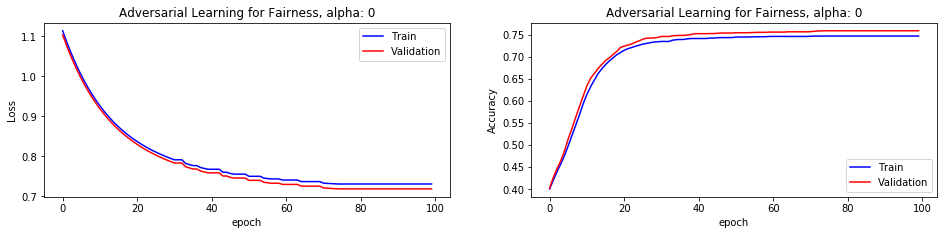

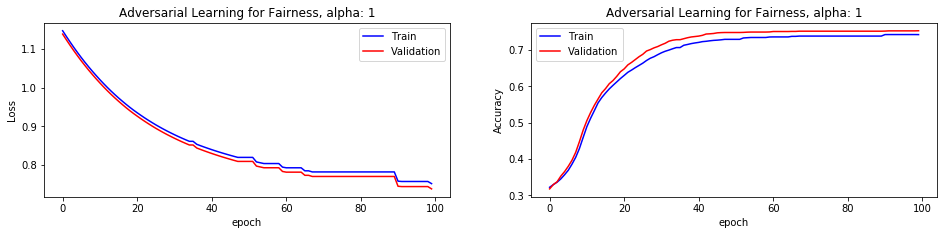

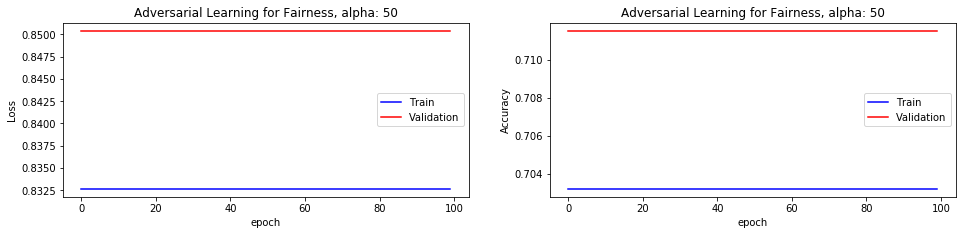

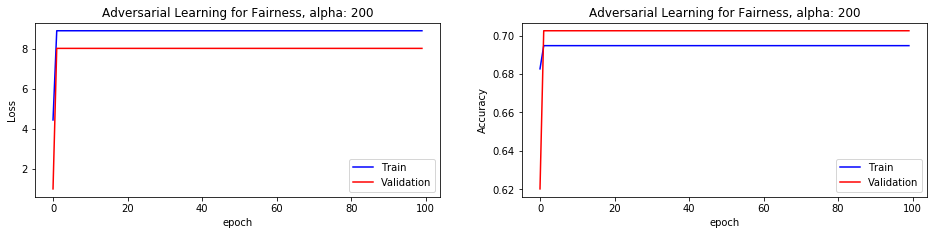

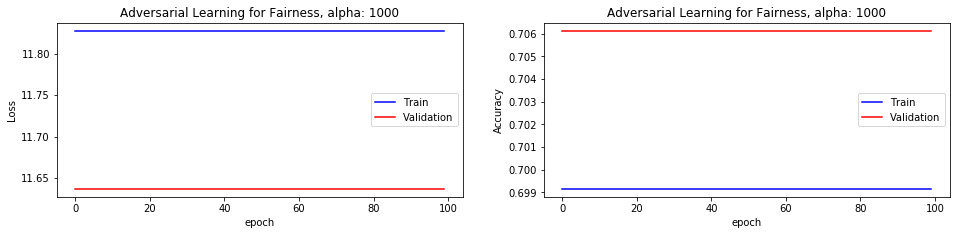

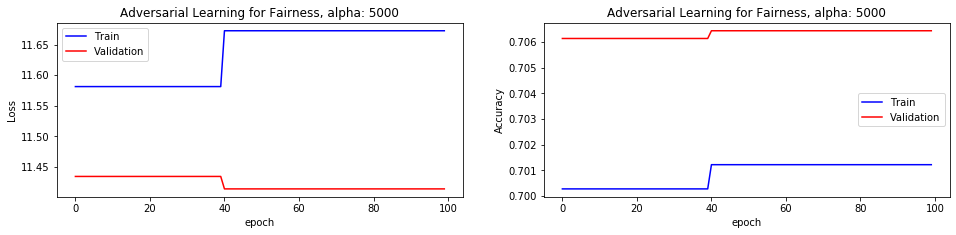

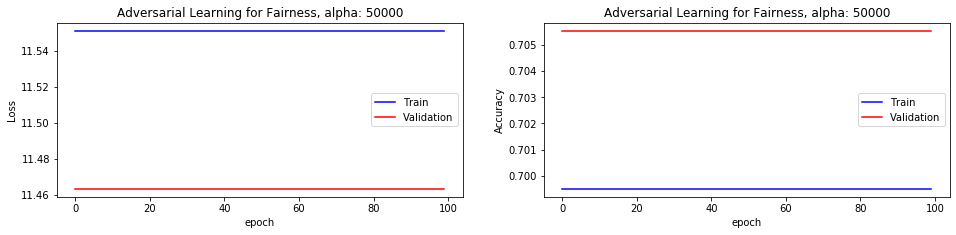

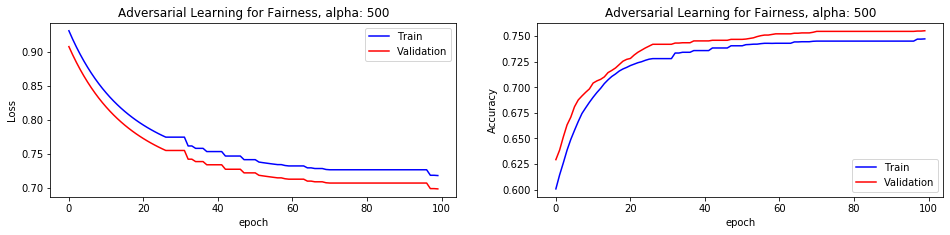

In [39]:
Adv2_f1s = []
Adv2_fnr_diffs = []
Adv2_fpr_diffs = []
Adv2_aucs = []
Adv2_accs = []
Adv2_accs_o = []
Adv2_accs_p = []
Adv2_fnr_fprs = []
n_splits = 0
batch_size = 64

a_range = [0, 1, 50, 200, 1000, 5000, 50000, 500]
epochs = 100
batch_size = 64
lr = 0.0001
d = 2

skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    n_splits +=1
    X_train_, X_test_ = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = StandardScaler()

    X_train_[:, 0:7] = scaler.fit_transform(X_train_[:, 0:7])
    X_test_[:, 0:7] = scaler.fit_transform(X_test_[:, 0:7])

    X_train = X_train_#[:,0:9]
    X_test = X_test_#[:,0:9]

    training_features_tensor = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
    training_labels_tensor = torch.tensor(y_train, requires_grad=False, dtype=torch.float)

    test_features_tensor = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
    test_labels_tensor = torch.tensor(y_test, requires_grad=False, dtype=torch.float)
    
    # create Tensor datasets
    train_data = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
    val_data = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
    valid_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = False)

    d_s = []
    a_s = []
    fnr_diffs = []
    fpr_diffs = []
    fnr_fprs = []
    accs = []
    accs_o = []
    accs_p = []
    best_epochs = []
    f1s = []
    fnr_os = []
    fnr_ps = []
    fpr_os = []
    fpr_ps = []
    aucs = []

    for a in a_range:
        e_valid_acc = 0
        #e_valid_fnr_fpr = 1
        #e_valid_f1 = 0
        
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        # create Tensor datasets
        train_data = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
        val_data = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)

        # dataloaders
        train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
        valid_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = False)

        model = Adv_full().to(device)
        P_params = [model.linear1.weight, model.linear1.bias]
        A_params = [model.linear2.weight, model.linear2.bias, model.c]

        # loss function - using cross entropy loss
        criterion = nn.BCELoss(weight = class_weights)
        criterion_A = nn.BCELoss()
        optimizer = optim.SGD(P_params, lr=lr)
        optimizer_A = optim.SGD(A_params, lr=lr)

        print("Running combination:")
        print("alpha: ", a)
        print("d: ", d)

        for epoch in range(epochs):

            train_loss, train_acc, train_f1, train_auc, train_loss_A, train_acc_A = train_Ad(model, train_loader, optimizer, optimizer_A, criterion, criterion_A, a)
            valid_loss, valid_acc, valid_loss_A, valid_acc_A, valid_f1, valid_auc, _, _, p_mean, o_mean, p_fpr, o_fpr, p_fnr, o_fnr, acc_p, acc_o, f1_p, f1_o = evaluate_Ad(model, valid_loader, criterion, criterion_A)

            fnr_diff = np.absolute(o_fnr - p_fnr)
            fpr_diff = np.absolute(o_fpr - p_fpr)
            fnr_fpr = (fnr_diff + fpr_diff)/2

            if valid_acc > e_valid_acc:
                    e_train_loss = train_loss
                    e_train_acc = train_acc
                    e_train_f1 = train_f1
                    e_train_auc = train_auc

                    e_valid_loss = valid_loss
                    e_valid_acc = valid_acc
                    e_valid_f1 = valid_f1
                    e_valid_auc = valid_auc
                    e_valid_fnr_diff = fnr_diff
                    e_valid_fpr_diff = fpr_diff
                    e_valid_fnr_fpr = fnr_fpr
                    e_valid_o_fnr = o_fnr
                    e_valid_o_fpr = o_fpr
                    e_valid_p_fnr = p_fnr
                    e_valid_p_fpr = p_fpr
                    e_valid_o_acc = acc_o
                    e_valid_p_acc = acc_p
                    e_valid_o_f1 = f1_o
                    e_valid_p_f1 = f1_p
                    best_epoch = epoch
                    torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': e_valid_loss,
                    }, 'best_adv_model.pt')

            if epoch%(epochs//10) == 0:

                print(f'Epoch: {epoch+1:02}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print(f'\t Val Protected FPR: {p_fpr:.3f}')
                print(f'\t Val Other FPR: {o_fpr:.3f}')
                print(f'\t Val Protected FNR: {p_fnr:.3f}')
                print(f'\t Val Other FNR: {o_fnr:.3f}')

            train_losses.append(e_train_loss)
            train_accs.append(e_train_acc)
            val_losses.append(e_valid_loss)
            val_accs.append(e_valid_acc)
            
        if n_splits == 1:
            title = ("Adversarial Learning for Fairness, alpha: " + str(a))
            plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, title)
        a_s.append(a)
        fnr_diffs.append(e_valid_fnr_diff)
        fpr_diffs.append(e_valid_fpr_diff)
        fnr_fprs.append(e_valid_fnr_fpr)
        fnr_os.append(e_valid_o_fnr)
        fnr_ps.append(e_valid_p_fnr)
        fpr_os.append(e_valid_o_fpr)
        fpr_ps.append(e_valid_p_fpr)
        f1s.append(e_valid_f1)
        aucs.append(e_valid_auc)
        accs.append(e_valid_acc)
        accs_o.append(e_valid_o_acc)
        accs_p.append(e_valid_p_acc)  
    Adv2_f1s.append(f1s)
    Adv2_fnr_diffs.append(fnr_diffs)
    Adv2_fpr_diffs.append(fpr_diffs)
    Adv2_aucs.append(aucs)
    Adv2_accs.append(accs)
    Adv2_accs_o.append(accs_o)
    Adv2_accs_p.append(accs_p)
    Adv2_fnr_fprs.append(fnr_fprs)


In [40]:
data = {'a': a_range, 'mean acc': np.mean(Adv2_accs, axis=0), 'std acc': np.std(Adv2_accs, axis=0),\
        'mean f1': np.mean(Adv2_f1s, axis=0), 'std f1': np.std(Adv2_f1s, axis=0), 'mean auc': np.mean(Adv2_aucs, axis=0),\
        'std auc': np.std(Adv2_aucs, axis=0), 'mean acc prot': np.mean(Adv2_accs_p, axis=0),\
        'std acc prot': np.std(Adv2_accs_p, axis=0), 'mean acc other': np.mean(Adv2_accs_o, axis=0), 'std acc other': np.std(Adv2_accs_o, axis=0),\
        'mean FPR diff': np.mean(Adv2_fpr_diffs, axis=0), 'std FPR diff': np.std(Adv2_fpr_diffs, axis=0),\
        'mean FNR diff': np.mean(Adv2_fnr_diffs, axis=0), 'std FNR diff': np.std(Adv2_fnr_diffs, axis=0),\
        'mean av diffs': np.mean(Adv2_fnr_fprs, axis=0), 'std av diffs': np.std(Adv2_fnr_fprs, axis=0)}

results_df = pd.DataFrame (data, columns = ['a', 'mean acc', 'std acc', 'mean f1', 'std f1', 'mean auc', 'std auc', \
                                            'mean acc prot', 'std acc prot', 'mean acc other', 'std acc other', \
                                            'mean FPR diff', 'std FPR diff', 'mean FNR diff', 'std FNR diff', \
                                            'mean av diffs', 'std av diffs'])


#lr_results = {'a': 'LR Baseline', 'f1': LR_f1, 'auc': LR_auc, 'FNR Diff': LR_fnr_diff, 'FPR Diff': LR_fpr_diff, 'Mean FNR + FPR Diff': LR_fnr_fpr_av}

results_df = results_df.replace(500, 'var')

results_df = results_df.sort_values(by=['mean av diffs'])

print(results_df)

       a  mean acc   std acc   mean f1    std f1  mean auc   std auc  \
5   5000  0.701605  0.005640  0.761240  0.004439  0.679268  0.006111   
6  50000  0.701754  0.005466  0.761330  0.004406  0.678908  0.005727   
4   1000  0.701863  0.005666  0.761810  0.004714  0.692383  0.008481   
3    200  0.701344  0.005643  0.760768  0.004631  0.713851  0.011738   
2     50  0.667151  0.021394  0.731508  0.023900  0.701324  0.038091   
7    var  0.748173  0.005910  0.791317  0.004399  0.823366  0.007640   
0      0  0.747031  0.009349  0.790271  0.007587  0.821046  0.007901   
1      1  0.738613  0.009505  0.779517  0.010088  0.814121  0.010245   

   mean acc prot  std acc prot  mean acc other  std acc other  mean FPR diff  \
5       0.679164      0.008092        0.713881       0.007750       0.029705   
6       0.679383      0.010234        0.714475       0.008010       0.029576   
4       0.680192      0.009827        0.714453       0.008042       0.032163   
3       0.680546      0.008618 

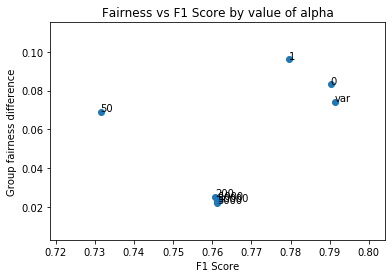

In [52]:
a_range = [0, 1, 50, 200, 1000, 5000, 50000, 500]
mean_f1s = np.mean(Adv2_f1s, axis=0)
mean_fnr_fprs = np.mean(Adv2_fnr_fprs, axis=0)

fig, ax = plt.subplots()
plt.title('Fairness vs F1 Score by value of alpha')
plt.xlabel('F1 Score')
plt.ylabel('Group fairness difference')
ax.scatter(mean_f1s, mean_fnr_fprs)
#ax.annotate('LR', (LR_f1, LR_fnr_fpr_av))
for i, txt in enumerate(a_range):
    if txt == 500:
        ax.annotate('var', (mean_f1s[i],mean_fnr_fprs[i]))
    else:
        ax.annotate(txt, (mean_f1s[i], mean_fnr_fprs[i]))
plt.savefig('alpha.png')
plt.show()

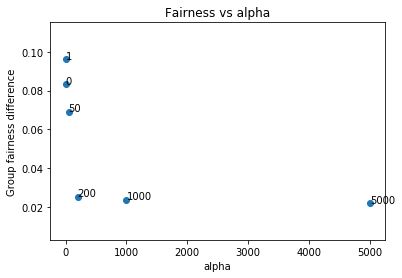

In [50]:
fig, ax = plt.subplots()
plt.title('Fairness vs alpha')
plt.xlabel('alpha')
plt.ylabel('Group fairness difference')
ax.scatter(a_range[:6], mean_fnr_fprs[:6])
#ax.annotate('LR', (LR_f1, LR_fnr_fpr_av))
for i, txt in enumerate(a_range[:6]):
    ax.annotate(txt, (a_range[i], mean_fnr_fprs[i]))
plt.savefig('alpha_fairness.png')
plt.show()

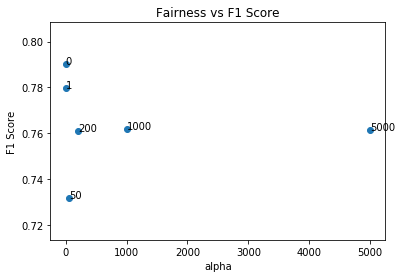

In [51]:
fig, ax = plt.subplots()
plt.title('Fairness vs F1 Score')
plt.xlabel('alpha')
plt.ylabel('F1 Score')
ax.scatter(a_range[:6], mean_f1s[:6])
#ax.annotate('LR', (LR_f1, LR_fnr_fpr_av))
for i, txt in enumerate(a_range[:6]):
    ax.annotate(txt, (a_range[i], mean_f1s[i]))
plt.savefig('alpha_f1.png')
plt.show()